In [1]:
#!import "setup.ipynb"

using PdfLexer.Content;

## PDF Text Extraction

PdfLexer provides multiple ways to extract text from pdf pages:
* **TextScanner** - Lowest level and most performant method for text extraction. Scans over individual characters on the page. Accessed via *PdfPage.GetTextScanner()*.
* **SimpleWordScanner** - Scans over letters of a page grouping them into words based on spacing between previous and current character. This scanner will not produce accurate results if the pdf writes characters of a word out of order which is uncommon. Accessed via *Page.GetWordScanner()*.
* **GetTextVisually** - Returns a rough representation of the pages text similar to how it is shown in the PDF. Different font sizes and characters not neatly grouped into lines may not display accurately in the resulting text. This algorithm is a work in progress and behavior may change over time. Accessed via *Page.GetTextVisually()* extension method.

The PDF spec includes predefined character maps that can be used in some circumstances to extract the unicode value of glyphs when it would not otherwise be possible. Due to the size of the character maps, PdfLexer includes them in an optional nuget package `PdfLexer.CMaps`.  After adding the nuget reference, `CMaps.AddKnownPdfCMaps()` must be called in order to register them globally. Calling this a second time is a no-op and may be called multiple times without signifanct performance impact.

For the examples the "calgray.pdf" is used (displayed below).


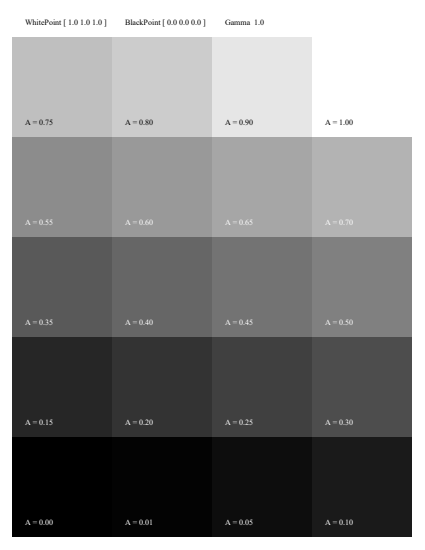

In [5]:
{
    using var doc = PdfDocument.Open(GetPdf("calgray.pdf"));
    display(doc.Pages[0]);
}

### GetTextVisually

In this examlpe the visual text representation for this pdf does a good job of showing the layout of the actual text but often has innacurate line representations when multiple font sizes are used.

In [2]:

{
    using var doc = PdfDocument.Open(GetPdf("calgray.pdf"));
    Console.WriteLine(doc.Pages.First().GetTextVisually());
}

       WhitePoint [ 1.0 1.0 1.0 ] BlackPoint [ 0.0 0.0 0.0 ] Gamma    1.0

       A = 0.75                   A  = 0.80                  A  = 0.90                   A = 1.00
       A = 0.55                   A  = 0.60                  A  = 0.65                   A = 0.70
       A = 0.35                   A  = 0.40                  A  = 0.45                   A = 0.50
       A = 0.15                   A  = 0.20                  A  = 0.25                   A = 0.30



### TextScanner

The TextScanner is a high performance utility for extraction characters / locations from pdf pages. It scans over each glyph on the page by using the `Advance()` method. A single glyph on a pdf page can represent multiple unicode characters and the unicode representation of a glyph is accessed via `Scanner.Glyph.Char` if it is a single character or `Scanner.Glyph.MultiChar` if it represents multiple characters. `Scanner.EnumerateCharacters()` can be used to simplify character access for each glyph covering both single and multicharacter scenarios.

`Scanner.GraphicsState` provides access to the PDF graphics state (font, color, size, etc) at the point the character was drawn.

The `TextScanner` is recommended for text extraction as it allows the user to segment characters in to words as needed for their use case. PdfLexer's word segmentation algorithms are not very robust at this time.

In [3]:
// text scanner is a ref struct, need to wrap in static non-async method for notebook
static void Run()
{
    using var doc = PdfDocument.Open(GetPdf("calgray.pdf"));
    var pg = doc.Pages.First();
    var scanner = pg.GetTextScanner();
    while (scanner.Advance()) 
    {
        Console.WriteLine("Font size: " + scanner.GraphicsState.FontSize);
        Console.WriteLine("Font: " + scanner.GraphicsState.FontObject);
        Console.WriteLine("Pos:  " + scanner.GetCurrentTextPos());
        Console.WriteLine("BBox:  " + scanner.GetCurrentBoundingBox());
        foreach (var charInfo in scanner.EnumerateCharacters())
        {
            Console.Write("char: " + charInfo.Char);
            Console.Write(" x: "+ charInfo.XPos);
            Console.Write(" y: "+ charInfo.YPos);
        }
        break; // just show info for first character for notebook
    }
}
Run();

Font size: 16
Font: <<Type Font Subtype Type1 BaseFont Times-Roman >>
Pos:  (50, 50)
BBox:  [50.24 50 61.296 60.784]
char: A x: 50 y: 50

### SimpleWordScanner

The SimpleWordScanner scans over each word on the page by using the `Advance()` method. 

`Scanner.GraphicsState` provides access to the PDF graphics state (font, color, size, etc) at the point the last character of the word was drawn.

In [4]:
// word scanner is a ref struct, need to wrap in static non-async method for notebook
static void Run()
{
    using var doc = PdfDocument.Open(GetPdf("calgray.pdf"));
    var pg = doc.Pages.First();
    var scanner = pg.GetWordScanner();
    while (scanner.Advance()) 
    {
        Console.WriteLine("Font size: " + scanner.GraphicsState.FontSize);
        Console.WriteLine(scanner.CurrentWord);
        Console.WriteLine(scanner.GetWordBoundingBox());
        break; // just show info for first character for notebook
    }
}
Run();

Font size: 16
A
[50.24 50 61.296 60.784]
